### Change to your own path

In [1]:
import sys
import os
script_path = os.path.abspath('')
module_path = script_path[:script_path.rfind('src')]+ 'src' + '/'
asset_path = script_path[:script_path.rfind('src')]+ 'asset' + '/'
sys.path.append(module_path)
from utils.Helper_functions import *
from utils.huffman import HuffmanCoding
from scipy import signal, fftpack
from scipy import ndimage, misc, interpolate
from struct import *
import matplotlib.pyplot as plt
import numpy as np

Loading BokehJS ...

In [9]:
fig = 'Andy_Video.png'
data_stack = imageStack_load(asset_path + fig)
print(data_stack.shape)
ori_file_size = os.path.getsize(asset_path+fig)
print(ori_file_size)

(7, 168, 400, 3)
1418415


In [9]:
a = np.ones([2,3,4,5,3])
rgb2ycrcbMat = np.array([[0.2990, 0.58700, 0.11400], [-0.16874, -0.33126, 0.50000], [0.50000, -0.41869, -0.0813]])
rgb2ycrcbMat
# np.multiple(a, rgb2ycrcbMat, )

array([[ 0.299  ,  0.587  ,  0.114  ],
       [-0.16874, -0.33126,  0.5    ],
       [ 0.5    , -0.41869, -0.0813 ]])

[[ 46  46  80  47  64  58  33  33  33 140  46  36  75  75  68  33  33  33
   46  33  33  49  75  33  22  33  61 100  33  47  46 100  36  55  61  61
   47   8 140  82  32  21  47  48  22  32  22  21   9  22  46  33  33  19
   33  22  33  33  22  33  22  33  22  22  22  19  22  22  33  22  19  22
   22  19  22  19  19  19  44  33   9  19  19  19   9  19  19   9  33   9
   19   9  19  19  19   8  19  19  19  19   9  19  19  19  19  22  19  22
   19  19  19  22  22  19  19  22  19  19   9  57  19  46  19  59  33  22
   57  22  19  22  44  22  19  21  33  19  19  19  22  57  19  44  19  22
   19  44  19  33  46  33  44  33  44  33  66  44  44  44  55  44  74  44
   44  54  55  55  54  54  54  65  55  74  33 145 111  44  44  55  44  66
   76  44  55  44  44  57  68  44  57  57  45  45  46  46  45  46  52  18
   45  44  57  22 106 133  22  81  46  46  44  57  22 123 124  33  66  55
   65  55  63  55  55  55  55  55  72  55  33 104 230  49  55  55  72  55
   71  72  55  55  55  71  71  55  71 

<Figure size 432x288 with 0 Axes>

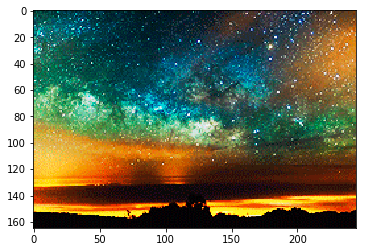

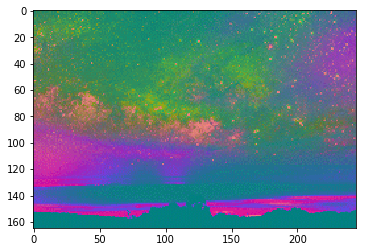

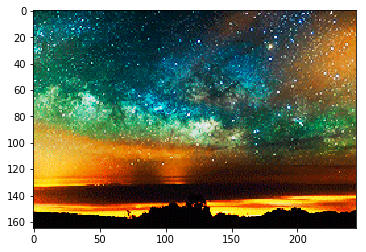

<Figure size 432x288 with 0 Axes>

In [16]:
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

test = data_stack[0]
plt.imshow(test)
plt.figure()
t = rgb2ycbcr(test)
plt.imshow(t)
plt.figure()


print(t[:,:,0])
re = ycbcr2rgb(t)
plt.imshow(re)
plt.figure()



In [3]:
def diagFlattenMat(npArray):
    # the array has to be a square matrix
    wid = npArray.shape[0]
    fliArr = np.flip(npArray, 0)
    run_list = []
    for i in range(1-wid, wid):
        run_list = run_list + list(np.diag(fliArr, k = i))
    return np.array(run_list)


def diagDeflattenMat(npArray):
    # the array is a 1d array
    wid = int(pow(npArray.shape[0], 1/2))
    mat = np.empty((wid, wid))
    for i in range(wid):
        for j in range(wid):
            if i+j <= wid-1:
                # on the top tri
                NO = sum([l for l in range(0, i + j + 1)]) + j + 1
            else:
                # on the bottom tri
                NO = pow(wid, 2) - sum([l for l in range(0, 2*wid - i -j - 2)]) + j - wid
                
            mat[i,j] = npArray[NO - 1]
    
    return mat.astype(int)
    
    
def getRunLen(npArray):
    # input array is flatten array
    
    count = 1
    result = []
    for i in range(npArray.shape[0]):
        if  i < npArray.shape[0] - 1 and npArray[i] == npArray[i+1]:
            count += 1
        else:
            result += [count]
            result += [npArray[i]]
            count = 1
    return np.array(result)

def reconRunLen(npArray):
    # len of input array has to be even
    result = []
    for i in range(npArray.shape[0] // 2):
        num = npArray[2*i]
        value = npArray[2*i + 1]
        result += [value for k in range(num)]
        
    return np.array(result)
    

In [16]:
class JPEG:
    # by defalut the DCT block size is 8*8!!!
    def __init__(self):
        self.xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
        self.Ql = np.array([[16,11,10,16,24,40,51,61],
                       [12,12,14,19,26,58,60,55],
                       [14,13,16,24,40,57,69,56],
                       [14,17,22,29,51,87,80,62],
                       [18,22,37,56,68,109,103,77],
                       [24,35,55,64,81,104,113,92],
                       [49,64,78,87,103,121,120,101],
                       [72,92,95,98,112,100,103,99]])
        self.Qc = np.array([[17,18,24,47,99,99,99,99],
                       [18,21,26,66,99,99,99,99],
                       [24,26,56,99,99,99,99,99],
                       [47,66,99,99,99,99,99,99],
                       [99,99,99,99,99,99,99,99],
                       [99,99,99,99,99,99,99,99],
                       [99,99,99,99,99,99,99,99],
                       [99,99,99,99,99,99,99,99]])

    def JPEG_com(self, npArray, params = {'Q':50, 'frame_rate': 10}):
        ori_f = npArray.shape[0]
        ori_h= npArray.shape[1]
        ori_w = npArray.shape[2]
        ori_c = npArray.shape[3]

    #     crBlock = params['baseline'] # 2 by default
        Q = params['Q']
        chBlock = 2
        blockSize = 8
        
        final_body = b''
        
        for i in range(ori_f):
            # process frame by frame
            # color decimate
            ycbcr = self.rgb2ycbcr(npArray[i])
#             plt.imshow(ycbcr[:,:,1])
#             plt.figure()
            pad_w = int(np.ceil(ori_w/blockSize) * blockSize)
            pad_h = int(np.ceil(ori_h/blockSize) * blockSize)
            pad_ycbcr = np.pad(ycbcr, ((0, pad_h-ori_h), (0, pad_w-ori_w), (0, 0)), 'constant', constant_values = (0,0))
            Cr = pad_ycbcr[:,:,2]
            deci_Cr = Cr[0:pad_h:chBlock, 0:pad_w:chBlock].repeat(2, axis = 0).repeat(2, axis = 1)
            pad_ycbcr[:,:,2] = deci_Cr

            Cb = pad_ycbcr[:,:,1]
            deci_Cb = Cr[0:pad_h:chBlock, 0:pad_w:chBlock].repeat(2, axis = 0).repeat(2, axis = 1)
            pad_ycbcr[:,:,1] = deci_Cb

            # 2d DCT
            dct_y,dct_cb,dct_cr = self.DCT2d(pad_ycbcr, pad_w, pad_h, blockSize)
            
#             if i == 1:
#                 print(dct_cb[:,:,20])
            
#             print(dct_y.shape)

            # quantization
            q_y, q_cb,q_cr=self.quantization(dct_y, dct_cb, dct_cr, Q)
        

#             print("shape after quan:")
            print(q_y.shape)
            # run length encoding
            y_code = self.runLength(q_y.astype(int))
            cb_code = self.runLength(q_cb.astype(int))
            print(q_cr.shape)
            cr_code = self.runLength(q_cr.astype(int))

            
            frame_code = y_code + cb_code + cr_code

            frame_flag = b'1010'
            frame_body = frame_flag\
                        + pack('I', len(y_code)) + pack('%sh' % len(y_code), *y_code)\
                        + pack('I', len(cb_code)) + pack('%sh' % len(cb_code), *cb_code)\
                        + pack('I', len(cr_code)) + pack('%sh' % len(cr_code), *cr_code)
    
            final_body += frame_body
        
#             print(len(y_code))
            
        # write to the bytes
        #-------init info-----------.#
        # frame
        #-------y-------.-------cb-------.-------cr-------.#
        # next frame
        #-------y-------.-------cb-------.-------cr-------.#
        # next frame
        #-------y-------.-------cb-------.-------cr-------.#   
        # ......
        # ......
#         print(len(final_code))
        # header encode
        origin_info = [ori_h, ori_w, ori_f, ori_c]
        compressed_info = [pad_h, pad_w, params['frame_rate']]
        info = origin_info+compressed_info
        new_info = [len(info)] + info
        header = pack('%sH' % len(new_info), *new_info)
        
#         body = pack('I', len(final_code)) + pack('%sH' % len(final_code), *final_code)
        return header + final_body
    
    
    ############## compression functions ################
    def rgb2ycbcr(self, im):
        ycbcr = im.dot(self.xform.T)
        ycbcr[:,:,[1,2]] += 128
        return ycbcr
    def ycbcr2rgb(self, im):
        xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
        rgb = im.astype(np.float)
        rgb[:,:,[1,2]] -= 128
        rgb = rgb.dot(xform.T)
        np.putmask(rgb, rgb > 255, 255)
        np.putmask(rgb, rgb < 0, 0)
        return np.uint8(rgb)

    def DCT2d(self, pad_ycbcr, pad_w, pad_h, blockSize):
        pad_y = pad_ycbcr[:, :, 0]
        pad_cb = pad_ycbcr[:, :, 1]
        pad_cr = pad_ycbcr[:, :, 2]

        blockNo = int(pad_w/blockSize * pad_h/blockSize)
        
        ystack = np.reshape(pad_y, (blockSize, blockSize, blockNo))
        cbstack = np.reshape(pad_cb, (blockSize, blockSize, blockNo))
        crstack = np.reshape(pad_cr, (blockSize, blockSize, blockNo))

        dct_y = np.empty(shape = ystack.shape)
        dct_cb = np.empty(shape = cbstack.shape)
        dct_cr = np.empty(shape = crstack.shape)

        for i in range(blockNo):
            dct_y[:,:,i] = fftpack.dct(fftpack.dct(ystack[:, :, i].T, norm='ortho').T, norm = 'ortho')

        for i in range(blockNo):
            dct_cb[:,:,i] = fftpack.dct(fftpack.dct(cbstack[:, :, i].T, norm='ortho').T, norm = 'ortho')


        for i in range(blockNo):
            dct_cr[:,:,i] = fftpack.dct(fftpack.dct(crstack[:, :, i].T, norm='ortho').T, norm = 'ortho')


#         return np.reshape(dct_y, (pad_h, pad_w)), np.reshape(dct_cb, (pad_h, pad_w)), np.reshape(dct_cr, (pad_h, pad_w))
        return dct_y, dct_cb, dct_cr

    def quantization(self, dct_y, dct_cb, dct_cr, Q):
        alph = lambda x:50/x if x<=50 else 2-x/50
        q_y = np.empty(shape=dct_y.shape)
        q_cb = np.empty(shape=dct_cb.shape)
        q_cr = np.empty(shape=dct_cr.shape)

    
        for i in range(dct_y.shape[2]):
            q_y[:,:,i] = np.around(np.multiply(dct_y[:,:,i], 1./(self.Ql*alph(Q))), decimals = 0)
            q_cb[:,:,i] = np.around(np.multiply(dct_cb[:,:,i], 1./(self.Qc*alph(Q))), decimals = 0)
            q_cr[:,:,i] = np.around(np.multiply(dct_cr[:,:,i], 1./(self.Qc*alph(Q))), decimals = 0)

#         return np.reshape(q_y.astype(int), (pad_h, pad_w)), np.reshape(q_cb.astype(int), (pad_h, pad_w)), np.reshape(q_cr.astype(int), (pad_h, pad_w))
        return q_y.astype(int),q_cb.astype(int),q_cr.astype(int)


    def requantization(self, dct_y, dct_cb, dct_cr, Q=50):
        alph = lambda x:50/x if x<=50 else 2-x/50
        q_y = np.empty(shape=dct_y.shape)
        q_cb = np.empty(shape=dct_cb.shape)
        q_cr = np.empty(shape=dct_cr.shape)

    
        for i in range(dct_y.shape[2]):
            q_y[:,:,i] = np.multiply(dct_y[:,:,i], (self.Ql*alph(Q)))
            q_cb[:,:,i] = np.multiply(dct_cb[:,:,i], (self.Qc*alph(Q)))
            q_cr[:,:,i] = np.multiply(dct_cr[:,:,i], (self.Qc*alph(Q)))

#         return np.reshape(q_y.astype(int), (pad_h, pad_w)), np.reshape(q_cb.astype(int), (pad_h, pad_w)), np.reshape(q_cr.astype(int), (pad_h, pad_w))
        return q_y,q_cb,q_cr
    
    def runLength(self, q):
        encoded_q = []
        for i in range(q.shape[2]):
#             print(q[:,:,i])
            flat_q = diagFlattenMat(q[:,:,i])
#             print(flat_q.shape)
            encoded_q += getRunLen(flat_q).tolist()
        return encoded_q
    
    
    
    
    ##############decompression functions###############
    def JPEG_decom(self, mainData):
        # get data and info
        by_len = 2
        header_len = unpack('H', mainData[0:by_len])
        header_end_idx = by_len*header_len[0]+by_len
        info = unpack('%sH' % (header_len[0]), mainData[by_len: header_end_idx])
        ori_h = info[0]
        ori_w = info[1]
        ori_f = info[2]
        ori_c = info[3]
        self.pad_h = info[4]
        self.pad_w = info[5]
        frame_rate = info[6]
        
#         print("a")
        
        # get every frames
        start_idx = header_end_idx
        array_stack = np.empty((ori_f, self.pad_h, self.pad_w, ori_c))
        recon = np.empty((ori_f, self.pad_h, self.pad_w, ori_c))


        i=0
#         print(mainData[start_idx:start_idx+4])
        while mainData[start_idx:start_idx+4] == b'1010':
            fStart = start_idx + 4
            ch_y_len = unpack('I', mainData[fStart:4+fStart])
#             print(ch_y_len[0])
            end_y = 4+by_len*ch_y_len[0]
            ch_y = unpack('%sh' % (ch_y_len[0]), mainData[4+fStart:end_y+fStart])
            
            # sorry I mistake the cb cr order
            ch_cr_len = unpack('I', mainData[end_y+fStart:end_y+4+fStart])
            end_cr = end_y+4+by_len*ch_cr_len[0]
            ch_cb = unpack('%sh' % (ch_cr_len[0]), mainData[end_y+4+fStart:end_cr+fStart])
            
            ch_cb_len = unpack('I', mainData[end_cr+fStart:4+end_cr+fStart])
            end_cb = end_cr+4+by_len*ch_cb_len[0]
            ch_cr = unpack('%sh' % (ch_cb_len[0]), mainData[4+end_cr+fStart:end_cb+fStart])
            
            y_ch = self.deRunLength(np.array(ch_y))
            cr_ch = self.deRunLength(np.array(ch_cr))
            cb_ch = self.deRunLength(np.array(ch_cb))
            
            
            
            y_ch, cb_ch, cr_ch = self.requantization(y_ch, cr_ch,cb_ch,Q=50)
            
            
#             print(y_ch.shape)
            pad_y, pad_cb, pad_cr = self.iDCT2d(y_ch, cb_ch, cr_ch)
            
            # ycbcr 2 rgb
            array_stack[i,:, :, 0] = pad_y
            array_stack[i,:, :, 1] = pad_cb
            array_stack[i,:, :, 2] = pad_cr
            
     
    
            recon[i,:,:,:] = self.ycbcr2rgb(array_stack[i,:,:,:])   
#             if i == 0:
#                 print(array_stack[i,:,:,0])
#                 print(array_stack.dtype)
#                 print(recon[i,:,:,0])


            plt.imshow(array_stack[i,:,:,0])
            plt.figure()
#             recon[i] = temp[i,:ori_h,:ori_w,:]
            start_idx = end_cb +fStart
#             print(mainData[start_idx:start_idx+4])
            i += 1
#             print(i)

        return recon,frame_rate
        # decode body

    
    def deRunLength(self, npArray):
        flatArray = reconRunLen(npArray)
#         print(npArray.shape)
#         print(flatArray.shape)
        channel = np.empty((8,8,flatArray.shape[0]//64))
        for i in range(flatArray.shape[0]//64):
            blockArray = diagDeflattenMat(flatArray[i*64:(i+1)*64])
            channel[:, :, i] = blockArray
        return channel
    
    def iDCT2d(self, y_ch, cb_ch, cr_ch):
#         print(y_ch.shape)
        idct_y = np.empty(shape = y_ch.shape)
        idct_cb = np.empty(shape = cb_ch.shape)
        idct_cr = np.empty(shape = cr_ch.shape)
        for i in range(y_ch.shape[2]):
            idct_y[:,:,i] = fftpack.idct(fftpack.idct(y_ch[:,:,i].T, norm='ortho').T, norm='ortho')
            idct_cb[:,:,i] = fftpack.idct(fftpack.idct(cb_ch[:,:,i].T, norm='ortho').T, norm='ortho')
            idct_cr[:,:,i] = fftpack.idct(fftpack.idct(cr_ch[:,:,i].T, norm='ortho').T, norm='ortho')

        
        pad_y = np.reshape(idct_y, (self.pad_h, self.pad_w))
        pad_cb = np.reshape(idct_cb, (self.pad_h, self.pad_w))
        pad_cr = np.reshape(idct_cr, (self.pad_h, self.pad_w))
    
        return pad_y, pad_cb, pad_cr
    
    

In [17]:
np.set_printoptions(threshold=sys.maxsize)
jpg = JPEG()
dct_y = jpg.JPEG_com(data_stack, {'Q':50, 'frame_rate': 10})

# dct_y

(8, 8, 1050)
(8, 8, 1050)
(8, 8, 1050)
(8, 8, 1050)
(8, 8, 1050)
(8, 8, 1050)
(8, 8, 1050)
(8, 8, 1050)
(8, 8, 1050)
(8, 8, 1050)
(8, 8, 1050)
(8, 8, 1050)
(8, 8, 1050)
(8, 8, 1050)


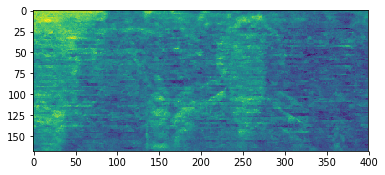

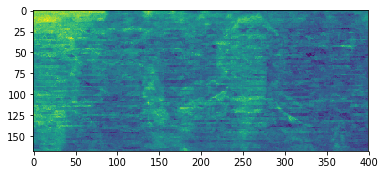

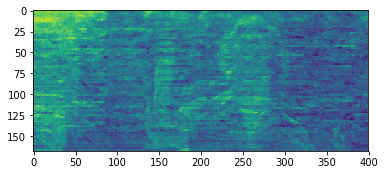

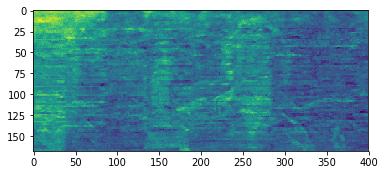

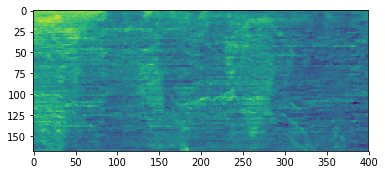

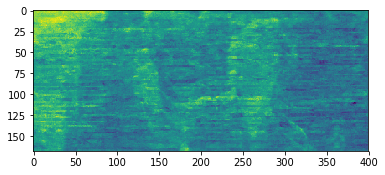

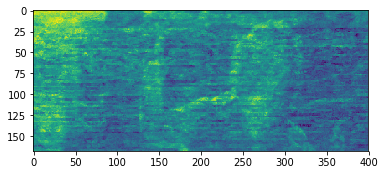

<Figure size 432x288 with 0 Axes>

In [18]:
rec = jpg.JPEG_decom(dct_y)

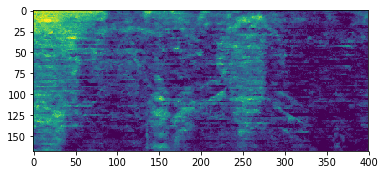

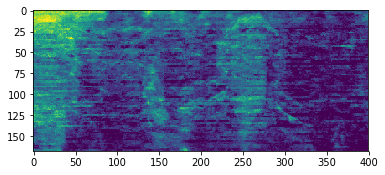

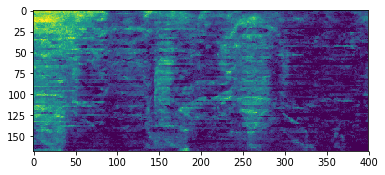

In [19]:
for i in range(3):
    plt.figure()
    plt.imshow(rec[i,:,:,2])

In [53]:
len(dct_y)
rec.shape
rec[1,:,:,0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

# unit function

In [36]:
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return ycbcr

def DCT2d(pad_ycbcr, pad_w, pad_h, blockSize):
    pad_y = pad_ycbcr[:, :, 0]
    pad_cb = pad_ycbcr[:, :, 1]
    pad_cr = pad_ycbcr[:, :, 2]
    
    blockNo = pad_w/blockSize * pad_h/blockSize

    ystack = reshape(pad_y, (blockSize, blockSize, blockNo))
    cbstack=reshape(pad_cb, (blockSize, blockSize, blockNo))
    crstack=reshape(pad_cr, (blockSize, blockSize, blockNo))
    
    dct_y = np.empty(shape = pad_y.shape)
    dct_cb = np.empty(shape = pad_y.shape)
    dct_cr = np.empty(shape = pad_y.shape)

    for i in range(blockNo):
        dct_y = dct(dct(ystack[i].T).T)
    
    for i in range(blockNo):
        dct_cb = dct(dct(cbstack[i].T).T)
        
    for i in range(blockNo):
        dct_cr = dct(dct(crstack[i].T).T)
        
    return np.reshape(dct_y, (pad_h, pad_w)), np.reshape(dct_cb, (pad_h, pad_w)), np.reshape(dct_cr, (pad_h, pad_w))

# def quantization(dct_y, dct_cb, dct_cr, Q):
def quantization(dct_y, Q= 50):

    Ql = np.array([[16,11,10,16,24,40,51,61],
                   [12,12,14,19,26,58,60,55],
                   [14,13,16,24,40,57,69,56],
                   [14,17,22,29,51,87,80,62],
                   [18,22,37,56,68,109,103,77],
                   [24,35,55,64,81,104,113,92],
                   [49,64,78,87,103,121,120,101],
                   [72,92,95,98,112,100,103,99]])
    Qc = np.array([[17,18,24,47,99,99,99,99],
                   [18,21,26,66,99,99,99,99],
                   [24,26,56,99,99,99,99,99],
                   [47,66,99,99,99,99,99,99],
                   [99,99,99,99,99,99,99,99],
                   [99,99,99,99,99,99,99,99],
                   [99,99,99,99,99,99,99,99],
                   [99,99,99,99,99,99,99,99]])
    
    alph = lambda x:50/x if x<=50 else 2-x/50
    
    q_y = np.around(np.multiply(dct_y, 1./(Ql*alph(Q))), decimals = 0)
#     q_cb = np.around(np.multiply(dct_cb, 1./(Qc*alph(Q))), decimals = 0)
#     q_cr = np.around(np.multiply(dct_cr, 1./(Qc*alph(Q))), decimals = 0)
                      
#     return q_y, q_cb,q_cr
    return q_y
    
    

# not now, not now
# def huffman_coding(nparry):
#     huff = HuffmanCoding()
#     huff.compress(nparray)



In [102]:
# def DCT2d(channel):
#     """
#     2d nparray
#     """
#     M = channel.shape[1] # width, x
#     N = channel.shape[0] # height, y
    
#     C_m = np.array([1/pow(2, 0.5)] + [1 for i in range(0, M-1)])
#     C_n = np.array([1/pow(2, 0.5)] + [1 for i in range(0, N-1)])

#     F = np.empty([M, N])
#     for x in range(M):
#         for y in range(N):
#             F[x,y] = channel[x, y]*cos((2*x + 1)*x)
            
#     F[x,y] = 2/pow(M*N, 0.5)*C_m[x]*C_n[y]*

    
# def DCT1d(channel):
    

In [101]:
from PIL import Image
im = Image.open(asset_path +"/milkyway/frame_01.tiff")
b = np.array(im)
a = np.empty([2,2])
a[0, 0] = 1
a.shape
c = np.empty(shape = a.shape)
a[0,0] =2
c[0,0] = 3
a
c
1<=2
np.around([0.57, 1.64], decimals = 0)
a = np.array([[1,2],[3,4]])
for number in a:
    print(number)

[1 2]
[3 4]


(165, 245, 3)
(170, 250)
(170, 250)
[[95.     95.     70.5203 ...  0.      0.      0.    ]
 [95.     95.     70.5203 ...  0.      0.      0.    ]
 [96.0325 96.0325 95.5    ...  0.      0.      0.    ]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]


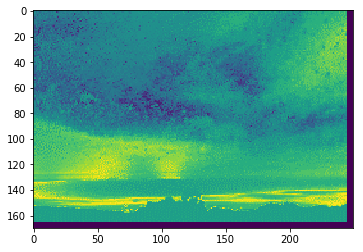

In [60]:
u = rgb2ycbcr(data_stack[0])
print(u.shape)
plt.imshow(u[:,:,2])
# print(u)
u_p = np.pad(u, ((0, 5), (0, 5),(0,0)), 'constant', constant_values = (0,0))
plt.imshow(u_p[:,:,2])
print(u_p[:,:,2].shape)
Cr = u_p[:,:,2]
deci_Cr = Cr[0:170:2, 0:250:2]
Cr_mean = deci_Cr.repeat(2, axis = 0).repeat(2, axis = 1)
u_p[:,:,2] = Cr_mean
print(Cr_mean.shape)
print(u_p[:,:,2])



In [40]:
np.ceil(20/8) * 8

24.0

In [42]:
x = np.arange(9).reshape((3,3))
x = np.array([[2,1,0],[2,0,0],[2,0,0]])
print(x)
print(np.flip(x, 1))
print(np.flip(x, 0))
print(np.flip(x))
print(np.diag(x, k=1))
print(np.diag(x, k =2))

[[2 1 0]
 [2 0 0]
 [2 0 0]]
[[0 1 2]
 [0 0 2]
 [0 0 2]]
[[2 0 0]
 [2 0 0]
 [2 1 0]]
[[0 0 2]
 [0 0 2]
 [0 1 2]]
[1 0]
[0]


In [48]:
k = diagFlattenMat(x)

In [49]:
m=np.empty((2,2))


In [57]:
r_x = diagDeflattenMat(k)

In [58]:
r_x

array([[2, 1, 0],
       [2, 0, 0],
       [2, 0, 0]])

In [59]:
for i in k:
    print(i)

2
2
1
2
0
0
0
0
0


In [53]:
k = np.array([0,1,1,1,1,1,0,0,2,3,4,4,5,0,0,0])
print(k)
n = getRunLen(k)
print(n)

[0 1 1 1 1 1 0 0 2 3 4 4 5 0 0 0]
[1 0 5 1 2 0 1 2 1 3 2 4 1 5 3 0]


In [83]:
m= reconRunLen(n)

In [84]:
m

array([0, 1, 1, 1, 1, 1, 0, 0, 2, 3, 4, 4, 5, 0, 0, 0, 1])

In [85]:
m == k

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [58]:
test = k.reshape((4,4))
a = np.empty((4,4))
a[:,0] = test[:,0]
a[:,1] = test[:,1]
a[:,2] = test[:,2]

In [59]:
test

array([[0, 1, 1, 1],
       [1, 1, 0, 0],
       [2, 3, 4, 4],
       [5, 0, 0, 0]])

In [60]:
a

array([[0.e+000, 1.e+000, 1.e+000, 5.e-324],
       [1.e+000, 1.e+000, 0.e+000, 1.e-323],
       [2.e+000, 3.e+000, 4.e+000, 2.e-323],
       [5.e+000, 0.e+000, 0.e+000, 0.e+000]])